In [2]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
import copy

import gc 

In [4]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import tensor_regression as tr
import tensor_regression.util
from tensor_regression import spectral_tensor_regression as STR
# from tensor_regression import standard_tensor_regression as STR

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import similarity
from basic_neural_processing_modules import math_functions
from basic_neural_processing_modules import misc
from basic_neural_processing_modules import decomposition
from basic_neural_processing_modules import linear_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib notebook

In [6]:
dir_data = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/for_batched_tensor_regression/upscaled alignment/'
# fileName_X_data = r'positions_convDR_meanSub_s2pInd.h5'
fileName_X_data = r'FR_positionsConvDRMeanSub_S2pInd_4xUpsampled.h5'

# fileName_y_data = r'neural_data.h5'
fileName_y_data = r'neuralData_aligned_4xUpsampled.h5'
path_neural_data_info = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/for_batched_tensor_regression/neural_data.h5'

positions = h5_handling.simple_load(directory=dir_data, fileName=fileName_X_data)
neural_data = h5_handling.simple_load(directory=dir_data, fileName=fileName_y_data)
neural_data_info = h5_handling.simple_load(path=path_neural_data_info)

In [7]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
device: 'cuda'


In [8]:
pos_array = positions['positions_convDR_meanSub_s2pInd']
print(f'pos_array.shape = {pos_array.shape}')

pos_array.shape = (432000, 2744)


<IPython.core.display.Javascript object>


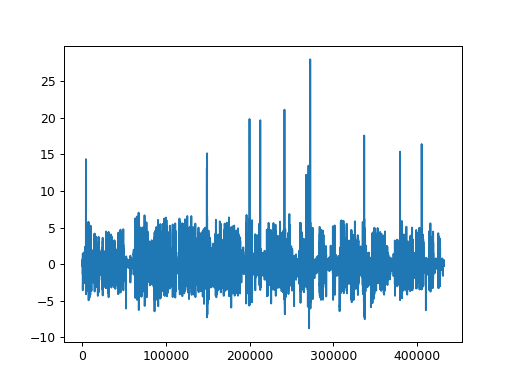

In [9]:
plt.figure()
plt.plot(pos_array[:,1200])

In [14]:
list(neural_data)

['F_aligned', 'Fneu_aligned', 'spks_aligned']

<IPython.core.display.Javascript object>


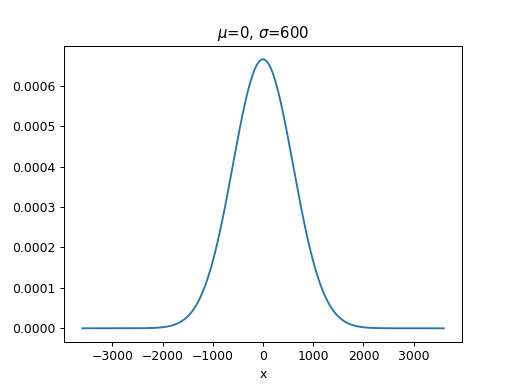

In [216]:
ic = neural_data_info['is_cell']
good_ROIs = neural_data_info['good_ROIs']
spks = torch.tensor(neural_data['spks_aligned'][ic][good_ROIs]).T
# F = torch.tensor(neural_data['F_aligned'][ic][good_ROIs]).T
Fs = 120
gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-Fs*30,(Fs*30)+1,1),
                                                                  mu=0,
                                                                  sig=5*Fs,
                                                                  plot_pref=True)

In [217]:
spks_conv = timeSeries.convolve_along_axis(spks,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='same',
                                             multicore_pref=True,
                                             verbose=True)

print(f'neural_array.shape = {spks_conv.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-15, 15]

ThreadPool elapsed time : 26.51 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 27.11 seconds
neural_array.shape = (432000, 811)


<IPython.core.display.Javascript object>


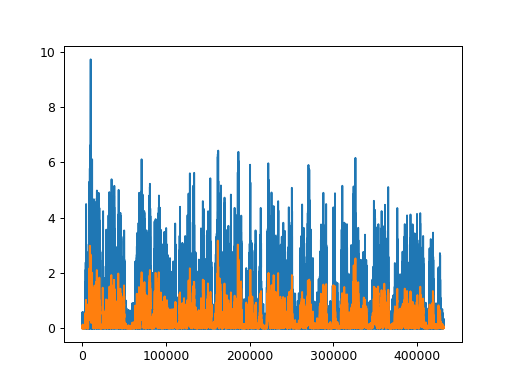

In [17]:
idx_toPlot = 35
plt.figure()
# plt.plot(dFoF[:,idx_toPlot])
plt.plot(spks[:,idx_toPlot]/40)
plt.plot(spks_conv[:,idx_toPlot]/40)

In [18]:
pos_array.shape

(432000, 2744)

In [19]:
pca_components, pca_scores, singVals, EVR = decomposition.torch_pca(pos_array, rank=pos_array.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

In [20]:
pca_components_norm, pca_scores_norm, singVals, EVR = decomposition.torch_pca(pos_array / np.linalg.norm(pos_array, axis=1, keepdims=True), rank=pos_array.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

torch_helpers.delete_all_cuda_tensors(globals())

In [21]:
pca_spks_components_norm, pca_spks_scores_norm, singVals_spks, EVR_spks = decomposition.torch_pca(spks_conv, rank=spks_conv.shape[1]//2, device='cuda', mean_sub=True, zscore=True, return_cpu=True, return_numpy=False)

torch_helpers.delete_all_cuda_tensors(globals())

<IPython.core.display.Javascript object>


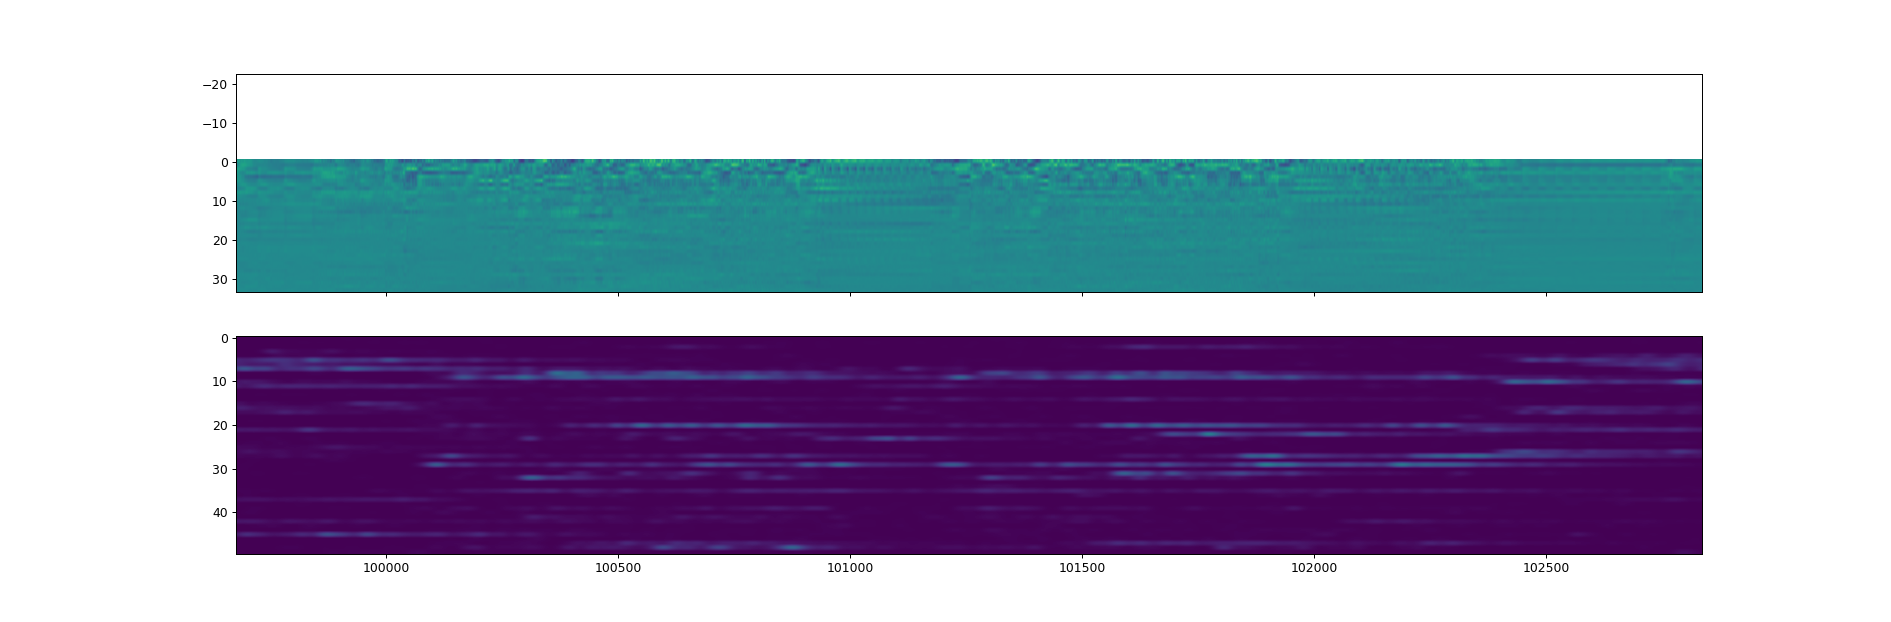

In [34]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].imshow(pca_scores_norm[:,:300].T, aspect='auto');
# axs[0].imshow((pca_scores[:,:10] / np.linalg.norm(pca_scores[:,:10],axis=1, keepdims=True)).T, aspect='auto');
# axs[1].plot(spks_conv[:,10])
axs[1].imshow(spks_conv[:,:50].T, aspect='auto');

In [242]:
Fs = 120
win_len = int(1 * Fs)
PCs_toUse = np.arange(0, 10)
# PCs_toUse = np.arange(0, 50)
neuron_toUse = np.arange(0, 800)
# neuron_toUse = 35
# dots_toUse = np.arange(0,2744,3)
dots_toUse = torch.randperm(2744)[:2744//200]
time_step = 120

In [243]:
## convert X time series into a time series of time window slices

# input_array = pca_scores[:, PCs_toUse]
input_array = torch.rand_like(pca_scores[:, PCs_toUse])
# input_array = pca_scores_norm[:, PCs_toUse]
# input_array = torch.diff(pca_scores_norm[:, PCs_toUse], dim=0, prepend=torch.zeros([1, len(PCs_toUse)]))
# input_array = torch.diff(pca_scores[:, PCs_toUse], dim=0, prepend=torch.zeros([1, len(PCs_toUse)]))
# input_array = torch.tensor(spks_conv[:, neuron_toUse], dtype=torch.float32)
# input_array = pos_array[:,dots_toUse] - timeSeries.mean_numba(pos_array.T)[None,:]
# input_array = torch.tensor(pos_array[:,dots_toUse], dtype=torch.float32)
# input_array = torch.tensor(input_array, dtype=torch.float32)
# input_array = input_array[:,:600]
# input_array = pos_array - np.mean(pos_array, axis=0, keepdims=True)
# input_array = pca_scores * pca_EVR
# input_array = input_array - input_array.mean(0)
# input_array = scipy.stats.zscore(input_array, axis=0)
# input_array = input_array / timeSeries.std_numba(input_array.T)[None,:]
# norm_factor = 1
# input_array = input_array*(1-norm_factor) + (input_array / torch.norm(input_array, dim=None))*(norm_factor)
# input_array = spks[:,neuron_toUse]
# input_array = torch.tensor(spks[:,neuron_toUse], dtype=torch.float32)
input_array = input_array - torch.mean(input_array, dim=0)

# win_halfLen = [win_len//2 if win_len>1 else 0]
n_samples = input_array.shape[0]
slice_idx = np.arange(win_len//2, n_samples - win_len//2, time_step)
n_slices = len(slice_idx)
n_features = input_array.shape[1]
# windowed_tensor = np.empty((n_slices, win_len, n_features), dtype=np.float32)
windowed_tensor = torch.empty((n_slices, win_len, n_features), dtype=torch.float32)
# windowed_tensor = np.empty((n_slices, 1, n_features), dtype=np.float32)
for ii, idx in enumerate(slice_idx):
#     ff_tensor[ii] = pos_array[idx:idx+win_len , :]
    windowed_tensor[ii] = input_array[idx-win_len//2:(idx+(win_len-1)//2) +1 , :]
#     windowed_tensor[ii] = input_array[idx-win_len//2:(idx+(win_len-1)//2) +1 , :] * np.hanning(win_len)[:,None]
#     windowed_tensor[ii] = input_array[idx:idx+1 , :]

X = windowed_tensor[:,:,:]

# X = torch.tensor(windowed_tensor[:50000,:,:2744//3], dtype=torch.complex64)
# X = X / torch.norm(X)
# X = X/50
# X = X - torch.mean(X, dim=1)[:,None,...]




# y = torch.tensor(spks[:, neuron_toUse].numpy(), dtype=torch.float32)[slice_idx]
# y = torch.tensor(spks_conv[:, neuron_toUse], dtype=torch.float32)[slice_idx]
# y = y - torch.mean(y, dim=0)
# y = y / torch.std(y, dim=0)

# y = torch.diff(pca_scores[:, PCs_toUse], dim=0, prepend=torch.zeros([1, len(PCs_toUse)]))[slice_idx]
# y = pca_scores[:, PCs_toUse][slice_idx]
# y = input_array[slice_idx]

# y = torch.tensor(pos_array[:,dots_toUse], dtype=torch.float32)[slice_idx]
y = torch.tensor(spks_conv[:,neuron_toUse], dtype=torch.float32)[slice_idx]
y = y - torch.mean(y, dim=0)
# y = y / torch.norm(y)


# y_conv = torch.tensor(spks_conv[:, neuron_toUse], dtype=torch.float32)[slice_idx]
# y_conv = y_conv - torch.mean(y_conv, dim=0)
# y_conv = y_conv / torch.std(y_conv, dim=0)
# y = scipy.stats.zscore(y, axis=0)
# y = torch.roll(y, 0*30, dims=0)
# y = y**(1/2)
# y = y / torch.norm(y)
# y = y*50

print(f'X size: {misc.estimate_size_of_float_array(input_shape=X.shape, bitsize=32)/1000000000} GB')
print(f'X tensor shape:  {X.shape}')
print('')
print(f'y size: {misc.estimate_size_of_float_array(input_shape=y.shape, bitsize=32)/1000000000} GB')
print(f'y tensor shape:  {y.shape}')

X size: 0.0172752 GB
X tensor shape:  torch.Size([3599, 120, 10])

y size: 0.0115168 GB
y tensor shape:  torch.Size([3599, 800])


In [244]:
torch_helpers.show_all_tensors(globals())

var: _,   device:cpu,   shape: torch.Size([17256, 800]),   size: 0.0552192 GB,   requires_grad: False
var: spks,   device:cpu,   shape: torch.Size([432000, 811]),   size: 1.401408 GB,   requires_grad: False
var: pca_components,   device:cpu,   shape: torch.Size([2744, 1372]),   size: 0.015059072 GB,   requires_grad: False
var: pca_scores,   device:cpu,   shape: torch.Size([432000, 1372]),   size: 2.370816 GB,   requires_grad: False
var: singVals,   device:cpu,   shape: torch.Size([1372]),   size: 5.488e-06 GB,   requires_grad: False
var: EVR,   device:cpu,   shape: torch.Size([1372]),   size: 5.488e-06 GB,   requires_grad: False
var: pca_components_norm,   device:cpu,   shape: torch.Size([2744, 1372]),   size: 0.015059072 GB,   requires_grad: False
var: pca_scores_norm,   device:cpu,   shape: torch.Size([432000, 1372]),   size: 2.370816 GB,   requires_grad: False
var: pca_spks_components_norm,   device:cpu,   shape: torch.Size([811, 405]),   size: 0.00262764 GB,   requires_grad: False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


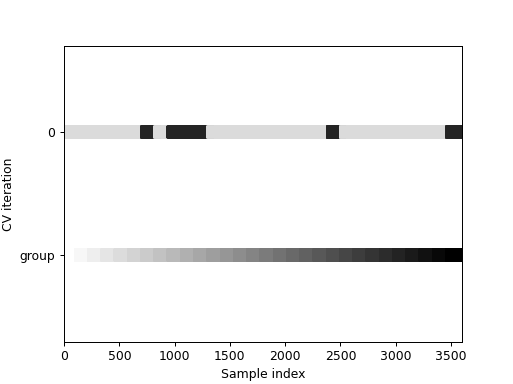

In [245]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs_X = Fs / time_step
group_len = 60*2 * Fs_X # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

device: 'cuda'


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: 0.0


<IPython.core.display.Javascript object>


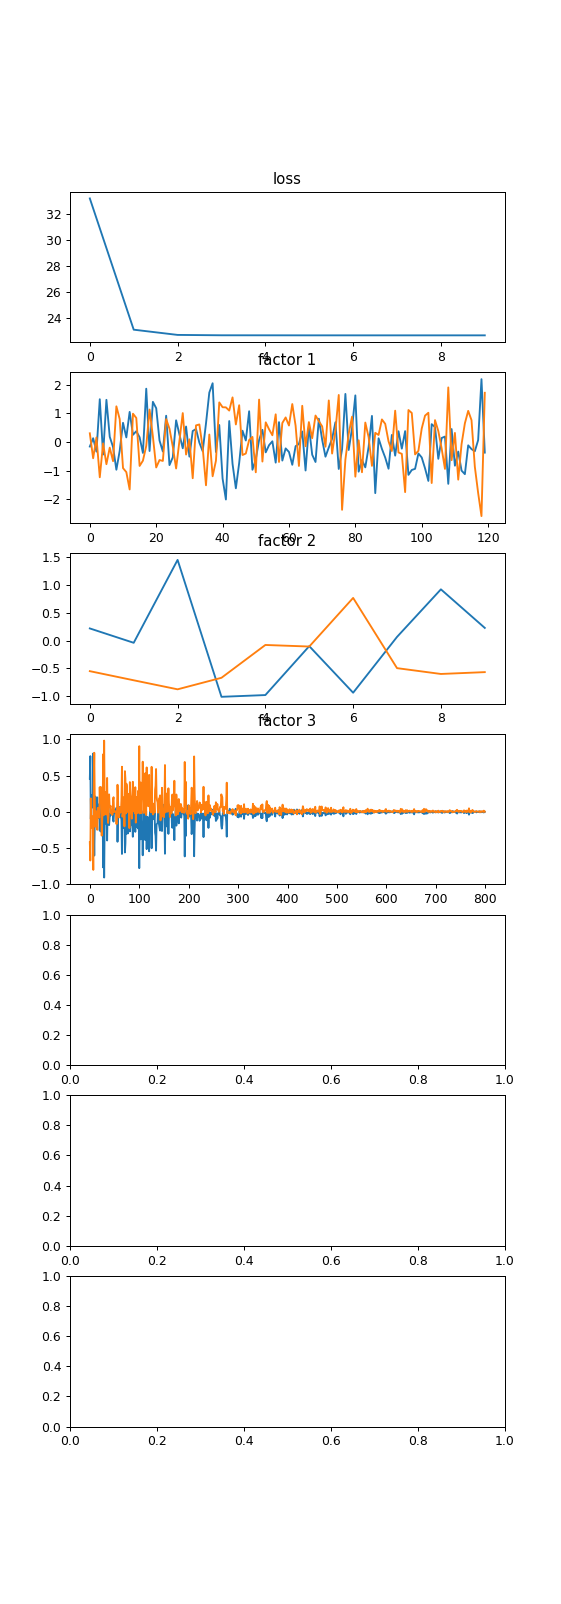

Iteration: 0, Loss: 33.220279693603516  ;  Variance ratio (y_hat / y_true): 0.41261102844412817
Iteration: 1, Loss: 23.075857162475586  ;  Variance ratio (y_hat / y_true): 0.02069448366210568
Iteration: 2, Loss: 22.67119789123535  ;  Variance ratio (y_hat / y_true): 0.03767720128749383
Iteration: 3, Loss: 22.64253807067871  ;  Variance ratio (y_hat / y_true): 0.038724213293828115
Iteration: 4, Loss: 22.640975952148438  ;  Variance ratio (y_hat / y_true): 0.03862005927321212
Iteration: 5, Loss: 22.638107299804688  ;  Variance ratio (y_hat / y_true): 0.03871624602881951
Iteration: 6, Loss: 22.63764190673828  ;  Variance ratio (y_hat / y_true): 0.03878968760951193
Iteration: 7, Loss: 22.63764190673828  ;  Variance ratio (y_hat / y_true): 0.03878968760951193
Iteration: 8, Loss: 22.63764190673828  ;  Variance ratio (y_hat / y_true): 0.03878968760951193
Iteration: 9, Loss: 22.63764190673828  ;  Variance ratio (y_hat / y_true): 0.03878968760951193
Convergence reached
loss: 22.63764190673828
E

In [247]:
%matplotlib notebook
import torch
from tqdm.notebook import tqdm, trange

DEVICE = tr.util.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
# h_vals = np.logspace(-5.5, -3.5, num=20, endpoint=True)
# h_vals = np.array([1e-1, 5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2, 0.05e-2])
# h_vals = np.array([1e1, 5e0, 2e0, 1e0, 5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 0])
# h_vals = np.array([2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 0])
# h_vals = np.array([0.002, 0.004, 0.006, 0.008, 0.01])
# h_vals = np.array([0.0000])
# h_vals = np.array([0.12])
h_vals = np.array([0.00])
# h_vals = np.array([10])


loss_all = []
params_all = []
EV_all = []
R_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')
#         dataloader, dataset, sampler = tr.util.make_WindowedDataloader(X_train, y_train, win_range=win_range, batch_size=60000, drop_last=True)

        cpmlr = STR.CP_linear_regression(
                                         X_train.shape,
                                         y_train.shape,
                                         rank_normal=2,
                                         rank_spectral=0,
                                         non_negative=[False, False, False],
                                         weights=None,
                                         Bcp_init=None,
                                             Bcp_init_scale=6,
#                                              Bcp_init_scale=0.03,
#                                          Bcp_init_scale=0.02,
                                         n_complex_dim=1,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )
        
#         cpmlr = STR.CP_linear_regression(
#                                          X_train.shape,
# #                                          y_train.shape,
#                                          rank=1,
#                                          non_negative=[False, False],
#                                          weights=None,
#                                          Bcp_init=None,
#                                              Bcp_init_scale=1,
# #                                              Bcp_init_scale=0.005,
# #                                          Bcp_init_scale=0.02,
# #                                          n_complex_dim=1,
#                                          device=DEVICE,
#                                          softplus_kwargs={
#                                              'beta': 50,
#                                              'threshold':1}
#                                          )


        # tic = time.time()
#         cpmlr.loss_running = [0]
        cpmlr.fit(X_train.to(DEVICE), y_train.to(DEVICE),
            lambda_L2=h_vals[ii], 
                    max_iter=800, 
                    tol=1e-5, 
                    patience=5,
                    verbose=3,
                    running_loss_logging_interval=1,
                    LBFGS_kwargs={
                        'lr' : 1, 
                        'max_iter' : 20, 
                        'max_eval' : None, 
                        'tolerance_grad' : 1e-07, 
                        'tolerance_change' : 1e-09, 
                        'history_size' : 100, 
                        'line_search_fn' : "strong_wolfe"
                    }
                 )

#         cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
#                         lambda_L2=h_vals[ii], 
#                         max_iter=20000, 
#                         tol=1e-6, 
#                         patience=10,
#                         verbose=3,
#                         plotting_interval=100,
#                     Adam_kwargs={
#                             'lr' : 0.002, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#                     )




#         cpmlr.fit_batch_Adam(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     n_iter_inner=10,
#                     verbose=2,
#                     Adam_kwargs={
#                             'lr' : 0.0005, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#              )
    
#         cpmlr.fit_batch_LBFGS(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     verbose=2,
#                     n_iter_inner=3,
#                     LBFGS_kwargs={
#                                     'lr' : 1, 
#                                     'max_iter' : 20, 
#                                     'max_eval' : None, 
#                                     'tolerance_grad' : 1e-07, 
#                                     'tolerance_change' : 1e-09, 
#                                     'history_size' : 100, 
#                                     'line_search_fn' : "strong_wolfe"
#                                 }
#              )

        # print(time.time() - tic)
        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        y_pred = cpmlr.predict(X_train)
        _, EV_train, EVtw_train, EVtu_train = similarity.pairwise_orthogonalization_torch(y_train.cpu(), y_pred, center=True)
        R_train = np.diag(similarity.pairwise_similarity(y_train.numpy(), y_pred.numpy(), method='pearson'))
        
        y_pred = cpmlr.predict(X_test)
        _, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(y_test.cpu(), y_pred, center=True)
        R_test = np.diag(similarity.pairwise_similarity(y_test.numpy(), y_pred.numpy(), method='pearson'))
        print(f'EV_train / EV_test: {EVtw_train} / {EVtw_test}  ;  R_train / R_test: {R_train.mean()} / {R_test.mean()}')
        
        EV_all.append([EV_train, EV_test])
        R_all.append([R_train, R_test])

In [126]:
test = cpmlr.get_params()['Bcp_n']

In [156]:
w = test[0].squeeze()

<IPython.core.display.Javascript object>


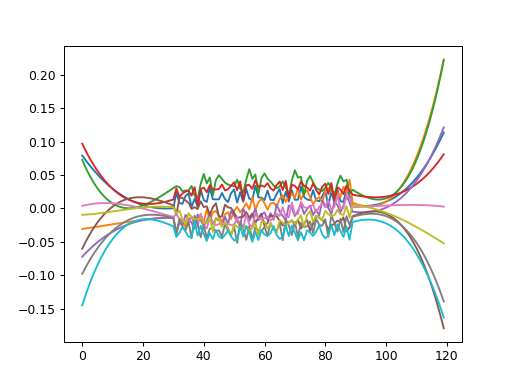

In [171]:
import scipy.signal

plt.figure()
# plt.plot(w)
plt.plot(scipy.signal.savgol_filter(w, 61,3, axis=0))

<IPython.core.display.Javascript object>


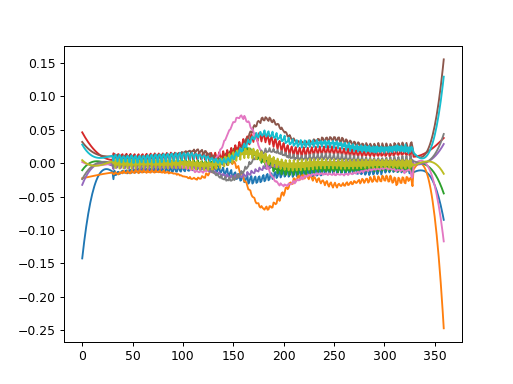

In [154]:
import scipy.signal

plt.figure()
# plt.plot(w)
plt.plot(scipy.signal.savgol_filter(w, 61,3, axis=0))

<IPython.core.display.Javascript object>


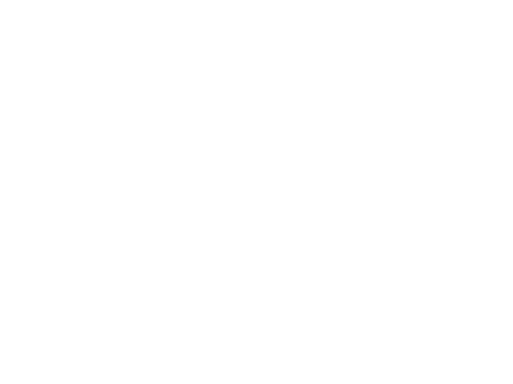

NameError: name 'out' is not defined

In [28]:
plt.figure()
plt.plot(-out[1][:,0]/1)
plt.plot(cpmlr.predict_latents(X))

<IPython.core.display.Javascript object>


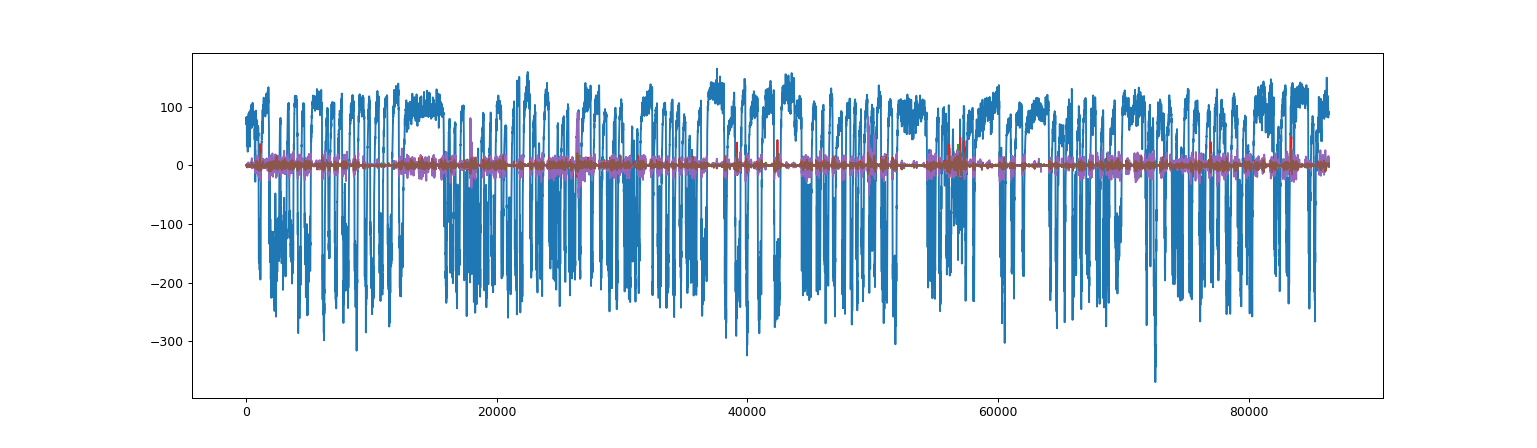

In [58]:
plt.figure()
plt.plot(out[1][:,0])
plt.plot(cpmlr.predict_latents(X_train)[:,0:5])

In [44]:
out = decomposition.torch_pca(y_train.squeeze(), device=DEVICE)

In [44]:
_, EV, EVtw, EVtu = similarity.pairwise_orthogonalization_torch(y_train.cpu(), torch.einsum('i,jk->ik', out[1][:,0], out[0]), center=True)
print(f'PC1 EV_train / EV_test: {EVtw}')

PC1 EV_train / EV_test: 0.21784263849258423


In [91]:
y_pred = cpmlr.predict(X_train)
_, EV_train, EVtw_train, EVtu_train = similarity.pairwise_orthogonalization_torch(y_train.cpu(), y_pred, center=True)
R_train = np.diag(similarity.pairwise_similarity(y_train.numpy(), y_pred.numpy(), method='pearson'))

y_pred = cpmlr.predict(X_test)
_, EV_test, EVtw_test, EVtu_test = similarity.pairwise_orthogonalization_torch(y_test.cpu(), y_pred, center=True)
R_test = np.diag(similarity.pairwise_similarity(y_test.numpy(), y_pred.numpy(), method='pearson'))
print(f'EV_train / EV_test: {EVtw_train} / {EVtw_test}  ;  R_train / R_test: {R_train.mean()} / {R_test.mean()}')

EV_train / EV_test: 0.14384497702121735 / 0.17706181108951569  ;  R_train / R_test: 0.2593644857406616 / 0.2781054973602295


<IPython.core.display.Javascript object>


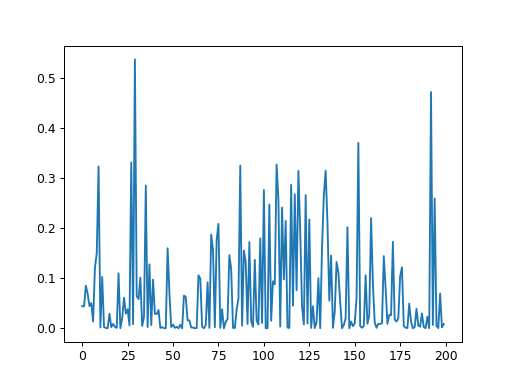

In [219]:
plt.figure()
plt.plot(EV_test)

In [30]:
y_train.shape

torch.Size([104100, 20])

In [50]:
import tensorly.decomposition

tca_obj = tl.decomposition.CP(rank=2,
                                      n_iter_max=100,
                                      tol=1e-08,
                                      init='random',
                                      svd='symeig_svd',
                                      l2_reg=0,
                                      linesearch=False,
                                      fixed_modes=None,
                                      normalize_factors=False,
                                      orthogonalise=False,
                                      sparsity=None,
                                      mask=None,
                                      svd_mask_repeats=5,
                                      cvg_criterion='abs_rec_error',
                                      random_state=None,
                                      verbose=1)

test = tca_obj.fit_transform(y_train.to(DEVICE))

reconstruction error=0.8632908463478088
iteration 1, reconstruction error: 0.8207253217697144, decrease = 0.04256552457809448, unnormalized = 34273.84765625
iteration 2, reconstruction error: 0.8027620911598206, decrease = 0.0179632306098938, unnormalized = 33523.6953125
iteration 3, reconstruction error: 0.7915963530540466, decrease = 0.011165738105773926, unnormalized = 33057.41015625
iteration 4, reconstruction error: 0.7869008779525757, decrease = 0.004695475101470947, unnormalized = 32861.32421875
iteration 5, reconstruction error: 0.7851574420928955, decrease = 0.0017434358596801758, unnormalized = 32788.51953125
iteration 6, reconstruction error: 0.7845654487609863, decrease = 0.0005919933319091797, unnormalized = 32763.796875
iteration 7, reconstruction error: 0.7843919992446899, decrease = 0.00017344951629638672, unnormalized = 32756.552734375
iteration 8, reconstruction error: 0.7843266129493713, decrease = 6.538629531860352e-05, unnormalized = 32753.822265625
iteration 9, re

iteration 76, reconstruction error: 0.784288763999939, decrease = 1.817941665649414e-05, unnormalized = 32752.2421875
iteration 77, reconstruction error: 0.7843058705329895, decrease = -1.710653305053711e-05, unnormalized = 32752.955078125
iteration 78, reconstruction error: 0.7842879891395569, decrease = 1.7881393432617188e-05, unnormalized = 32752.208984375
iteration 79, reconstruction error: 0.7843060493469238, decrease = -1.806020736694336e-05, unnormalized = 32752.96484375
iteration 80, reconstruction error: 0.7842880487442017, decrease = 1.800060272216797e-05, unnormalized = 32752.2109375
iteration 81, reconstruction error: 0.7843030691146851, decrease = -1.5020370483398438e-05, unnormalized = 32752.83984375
iteration 82, reconstruction error: 0.7842925786972046, decrease = 1.049041748046875e-05, unnormalized = 32752.40234375
iteration 83, reconstruction error: 0.7843025326728821, decrease = -9.953975677490234e-06, unnormalized = 32752.81640625
iteration 84, reconstruction error:

<IPython.core.display.Javascript object>


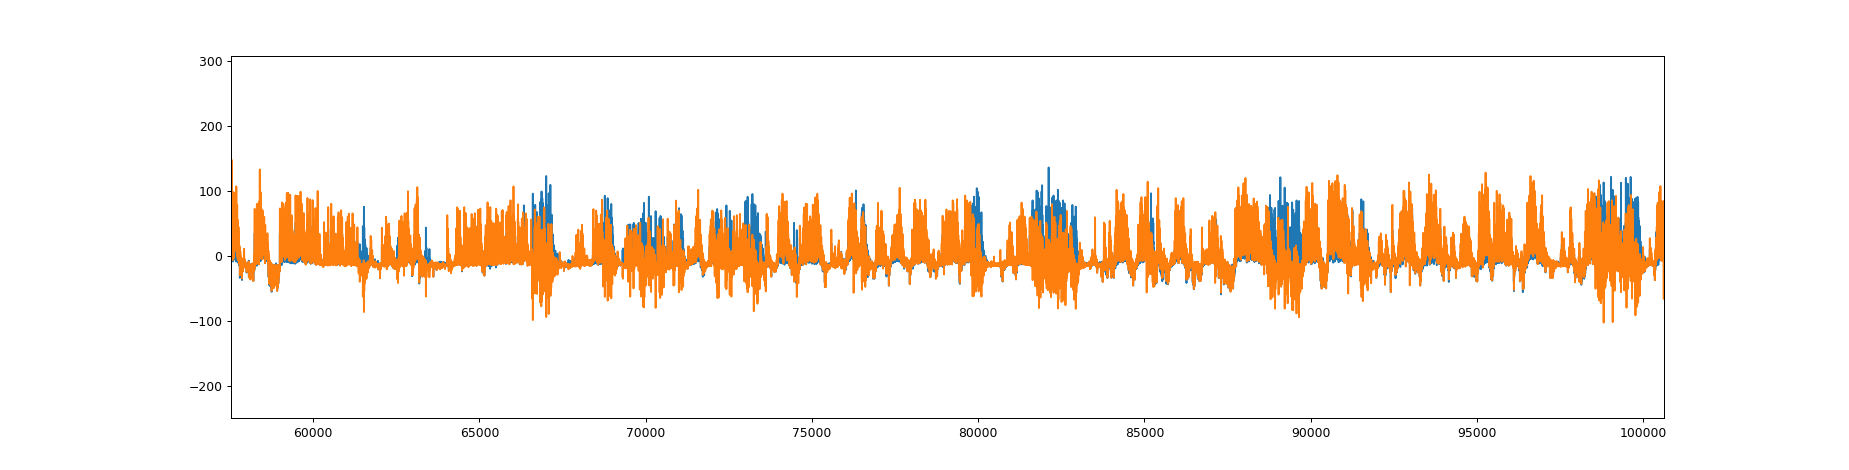

In [55]:
plt.figure()
plt.plot(out[1][:,0]/3)
plt.plot(-test.factors[0][:,0].cpu())

In [335]:
tensorly.SVD_FUNS

{'numpy_svd': <bound method Backend.partial_svd of <tensorly.backend.pytorch_backend.PyTorchBackend object at 0x7f8aec2f2940>>,
 'truncated_svd': <bound method Backend.truncated_svd of <tensorly.backend.pytorch_backend.PyTorchBackend object at 0x7f8aec2f2940>>,
 'symeig_svd': <bound method Backend.symeig_svd of <tensorly.backend.pytorch_backend.PyTorchBackend object at 0x7f8aec2f2940>>,
 'randomized_svd': <bound method Backend.randomized_svd of <tensorly.backend.pytorch_backend.PyTorchBackend object at 0x7f8aec2f2940>>}

In [107]:
cpmlr.optimizer.zero_grad()

<IPython.core.display.Javascript object>


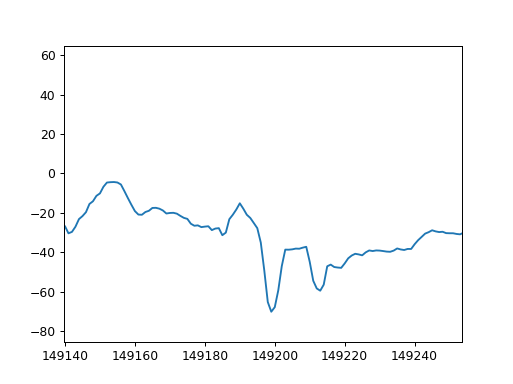

In [78]:
plt.figure()
plt.plot(pca_scores[:,30])

<IPython.core.display.Javascript object>


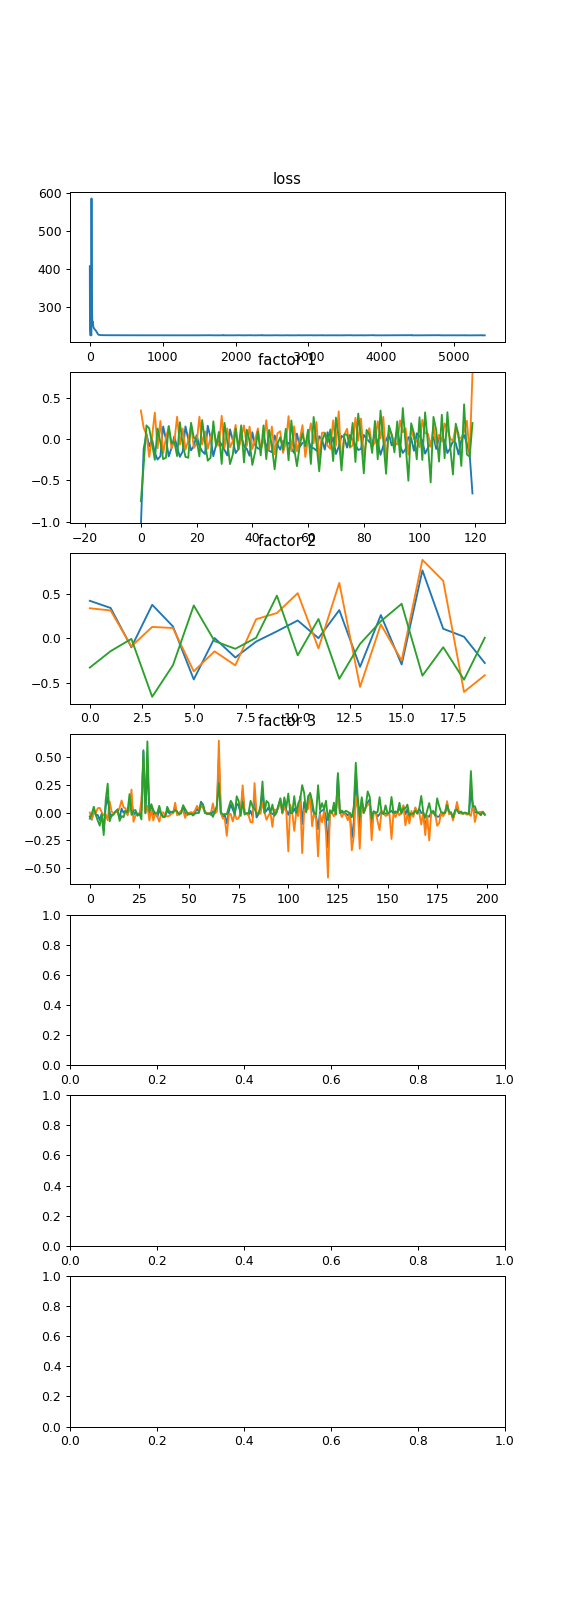

Iteration: 0, Loss: 225.70697021484375  ;  Variance ratio (y_hat / y_true): 0.13775752333981103
Iteration: 100, Loss: 227.1204376220703  ;  Variance ratio (y_hat / y_true): 0.13415714990749905
Iteration: 200, Loss: 226.00779724121094  ;  Variance ratio (y_hat / y_true): 0.1369527027720428
Iteration: 300, Loss: 225.89974975585938  ;  Variance ratio (y_hat / y_true): 0.13715386782674568
Iteration: 400, Loss: 225.84890747070312  ;  Variance ratio (y_hat / y_true): 0.13729204489584199
Iteration: 500, Loss: 225.81884765625  ;  Variance ratio (y_hat / y_true): 0.13730812352304034
Iteration: 600, Loss: 225.7987060546875  ;  Variance ratio (y_hat / y_true): 0.13739026592037737
Iteration: 700, Loss: 225.7830810546875  ;  Variance ratio (y_hat / y_true): 0.13740568857457125
Iteration: 800, Loss: 225.771240234375  ;  Variance ratio (y_hat / y_true): 0.13737663625906235
Iteration: 900, Loss: 225.76095581054688  ;  Variance ratio (y_hat / y_true): 0.13746210225295533
Iteration: 1000, Loss: 225.7530

KeyboardInterrupt: 

In [77]:
cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
                lambda_L2=h_vals[ii], 
                max_iter=20000, 
                tol=1e-6, 
                patience=10,
                verbose=3,
                plotting_interval=100,
            Adam_kwargs={
                    'lr' : 0.05, 
#                             'betas' : (0.9, 0.999), 
#                             'eps' : 1e-08, 
#                             'weight_decay' : 0, 
                    'amsgrad' : True
                }
            )


<IPython.core.display.Javascript object>


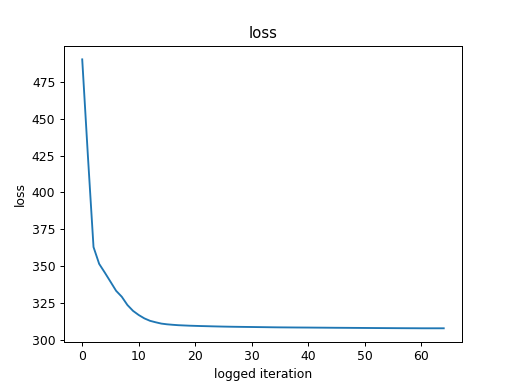

<IPython.core.display.Javascript object>


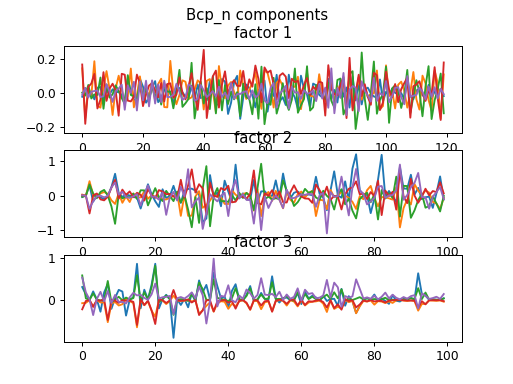

In [203]:
%matplotlib notebook
cpmlr.plot_outputs()

<IPython.core.display.Javascript object>


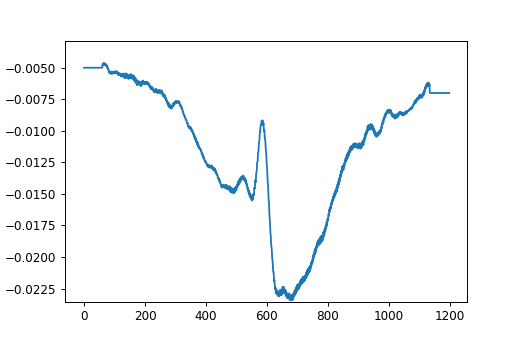

(-0.02576572820544243, -0.005090564489364624)

In [251]:
# new_trace = torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]),  15, 5)[0][:,None,None], dtype=torch.float32, device=DEVICE) + \
#             torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]), -15, 5)[0][:,None,None], dtype=torch.float32, device=DEVICE) + \
#             torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]), 0, 5)[0][:,None,None], dtype=torch.float32, device=DEVICE) 

# new_trace = torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]),  0, 0.1)[0][:,None,None], dtype=torch.float32, device=DEVICE)/5

# new_trace = (cpmlr.Bcp_n[0]*torch.tensor(timeSeries.idx2bool(timeIdx_toUse, X_test.shape[1]), device=DEVICE)[:,None, None]).detach()
# new_trace = copy.deepcopy(cpmlr.Bcp_n[0].detach()) * torch.hann_window(cpmlr.Bcp_n[0].shape[0], device=DEVICE)[:,None,None]
new_trace = copy.deepcopy(cpmlr.Bcp_n[0].detach())
new_trace[:60] = -0.005
new_trace[1135:] = -0.007

# new_trace[:200] = 0
# new_trace[2200:] = 0

# new_trace = new_trace - torch.mean(new_trace)
new_trace = new_trace

# new_trace = torch.ones(X.shape[1], dtype=torch.float32, device=DEVICE)[:,None,None]

plt.figure()
plt.plot(new_trace.cpu().numpy().squeeze())
plt.ylim([np.minimum(0,new_trace.cpu().min()*1.1), new_trace.cpu().max()*1.1])

R = 0.2512994110584259


<IPython.core.display.Javascript object>


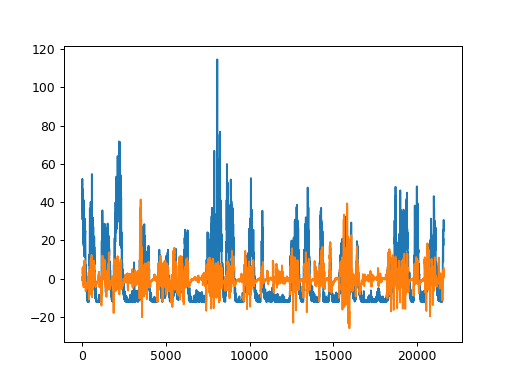

<IPython.core.display.Javascript object>


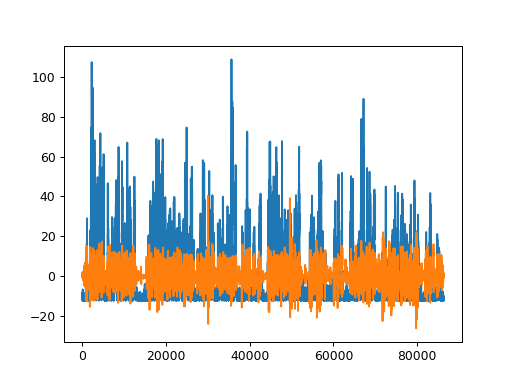

In [50]:
%matplotlib notebook

idx_toPlot = 35

# timeIdx_toUse = np.arange(200, 2200)

# y_hat_test = cpmlr.predict(X_test.cpu())
# y_hat_train = cpmlr.predict(X_train.cpu())

# new_trace = torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]), 20, 5)[0][:,None,None], dtype=torch.float32, device=DEVICE) + \
#             torch.tensor(math_functions.gaussian(np.linspace(-10,10, X.shape[1]), -20, 5)[0][:,None,None], dtype=torch.float32, device=DEVICE) 

# y_hat_test = cpmlr.predict(X_test[:,timeIdx_toUse,...][:,None,...].cpu(), [cpmlr.Bcp_n , [cpmlr.Bcp_c[0][timeIdx_toUse,...][None,:], cpmlr.Bcp_c[1]]])
# y_hat_test = cpmlr.predict(X_test[:,timeIdx_toUse,...].cpu(), [cpmlr.Bcp_n , [cpmlr.Bcp_c[0][timeIdx_toUse,...], cpmlr.Bcp_c[1]]])
# y_hat_test = cpmlr.predict(X_test.cpu(), [cpmlr.Bcp_n , [cpmlr.Bcp_c[0]*torch.tensor(timeSeries.idx2bool(timeIdx_toUse, X_test.shape[1]), device=DEVICE)[:,None, None], cpmlr.Bcp_c[1]]])
# y_hat_test = cpmlr.predict(X_test.cpu(), [[new_trace, cpmlr.Bcp_n[1], cpmlr.Bcp_n[2]] , cpmlr.Bcp_c])
y_hat_test = cpmlr.predict(X_test.cpu(), [[cpmlr.Bcp_n[0], cpmlr.Bcp_n[1], cpmlr.Bcp_n[2]] , cpmlr.Bcp_c])
y_hat_train = cpmlr.predict(X_train.cpu())

# y_hat_test = cpmlr.predict(X_test[:,31,:][:,None,:].cpu(), [cpmlr.Bcp[0][31,:][None,:], cpmlr.Bcp[1]])
# y_hat_train = cpmlr.predict(X_train.cpu())

print(f'R = {similarity.pairwise_similarity(y_hat_test.numpy()[:,idx_toPlot].squeeze()**1, y_test[:,idx_toPlot].cpu().detach().numpy().squeeze())[0][0]**1}')

plt.figure()
plt.plot(y_test[:,idx_toPlot]**1)
plt.plot(y_hat_test[:,idx_toPlot]**1)
# plt.plot(y_hat_test2[:,idx_toPlot])
# plt.plot(pca_scores[slice_idx[cv_idx[1]],2]/30)

plt.figure()
plt.plot(y_train[:,idx_toPlot])
plt.plot(y_hat_train[:,idx_toPlot])


In [36]:
slice_idx.shape

(53850,)

In [128]:
path_nwb = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/data/session.nwb'

from face_rhythm.util import helpers
helpers.dump_nwb(path_nwb)

import pynwb
from pynwb import NWBHDF5IO

with pynwb.NWBHDF5IO(path_nwb, mode='r') as io:
    file = io.read()
    pts_spaced_convDR = file.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]

CQT
     Sxx_allPixels:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_norm:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (30,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (309285, 3)   ,  float64   ,   0.007423 GB
     displacements:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     pointInds_toUse:    (3102, 1, 2)   ,  float32   ,   2.5e-05 GB
     positions_cleanup:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_cleanup_absolute:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_convDR_absolute:    (1372, 2, 436601)   ,  float64   ,   9.584265 GB
     positions_convDR_meanSub:    (1372, 2, 436601)   ,  float64   ,   9.584

In [129]:
def unmix_pcs(pca_components, weight_vecs):
    """
    Transforms weight_vecs into pca_components space
    RH 2021
    """
    if weight_vecs.ndim == 1:
        weight_vecs = weight_vecs[:,None]
    
    mixing_vecs = np.zeros((pca_components.shape[1], weight_vecs.shape[1]))
    mixing_vecs[:weight_vecs.shape[0],:] = weight_vecs

    return pca_components @ mixing_vecs

<IPython.core.display.Javascript object>


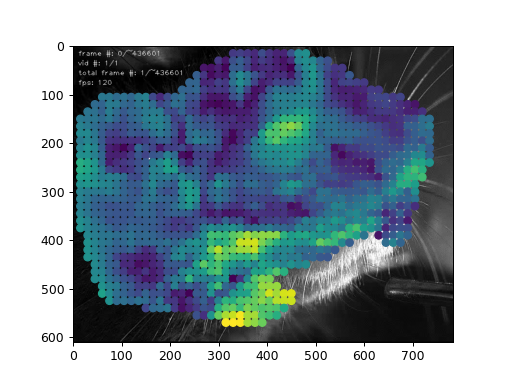

<IPython.core.display.Javascript object>


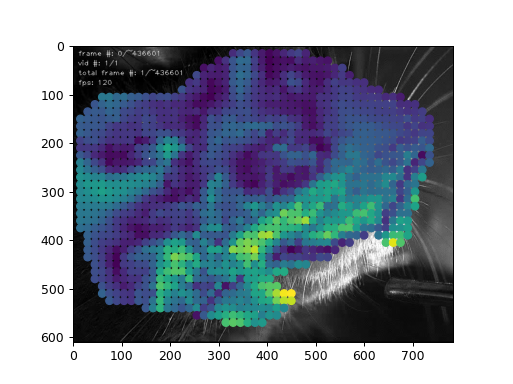

<IPython.core.display.Javascript object>


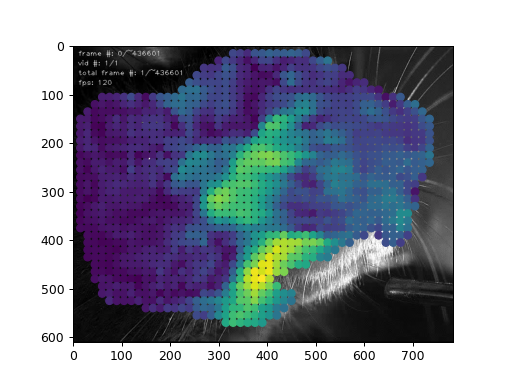

<IPython.core.display.Javascript object>


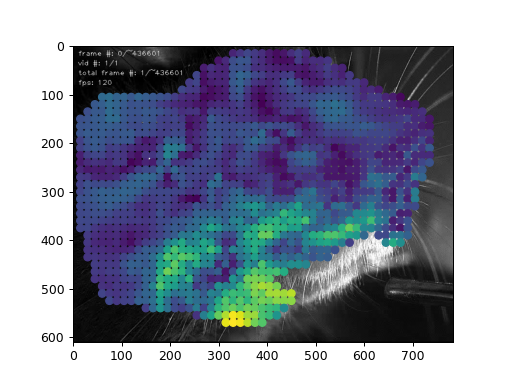

<IPython.core.display.Javascript object>


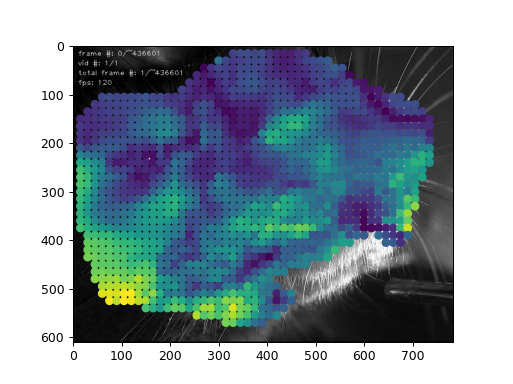

<IPython.core.display.Javascript object>


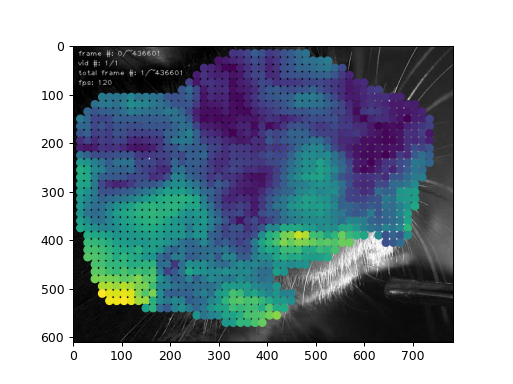

<IPython.core.display.Javascript object>


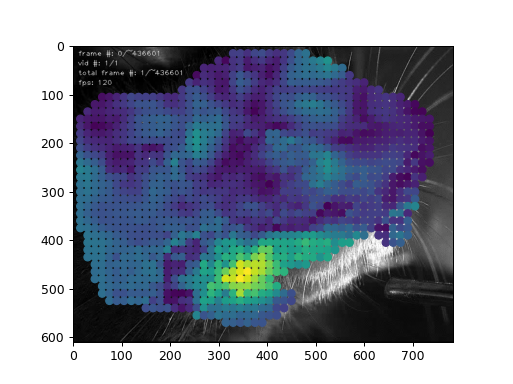

<IPython.core.display.Javascript object>


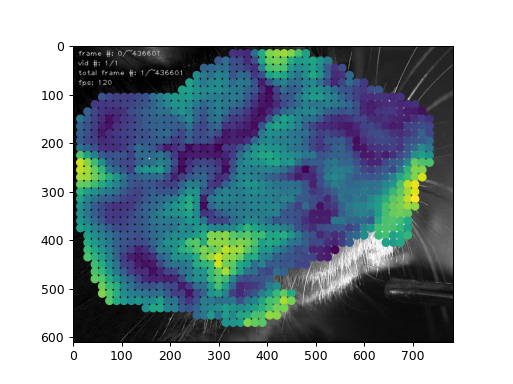

<IPython.core.display.Javascript object>


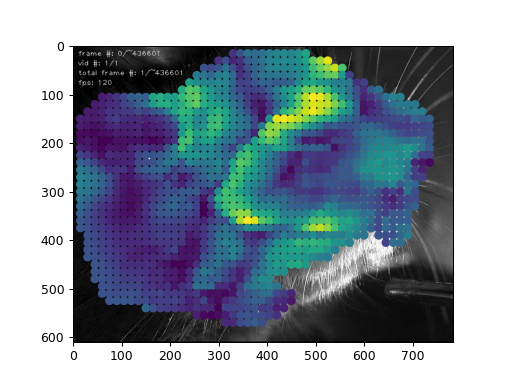

<IPython.core.display.Javascript object>


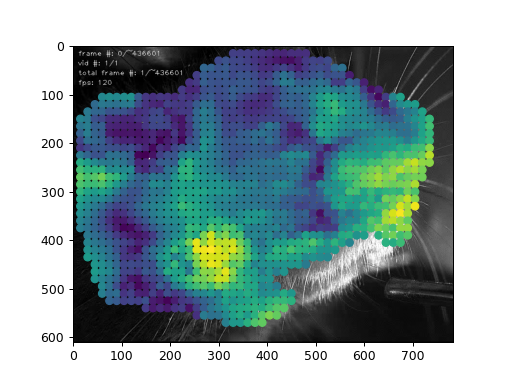

In [130]:
import imageio

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
# c_face_dots = unmix_pcs(pca_components, torch.tensor([0,0,0,0,0,0,0,0,0,0,1]))
# c_face_dots = unmix_pcs(pca_components, cpmlr.Bcp[1][:,:].cpu().detach().numpy().squeeze())
# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze()) * timeSeries.std_numba(pos_array.T)[:,None]
c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze())

# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze())
# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze() * np.var(pca_scores, axis=0)[:cpmlr.Bcp_n[1].shape[0], None])
# c_face_dots = unmix_pcs(pca_components, torch.sum(torch.vstack([cpmlr.Bcp_n[1][:,:,0][None,:], cpmlr.Bcp_c[1][:,:,0][None,:]]), dim=0).cpu().detach().numpy().squeeze())
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break
for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii]**1) # / np.mean(stds.reshape(len(stds)//2, 2), axis=1))

In [193]:
Fs = 120
PCs_toUse = np.arange(0, 300)
neuron_toUse = np.arange(0, 300)
# neuron_toUse = 35

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


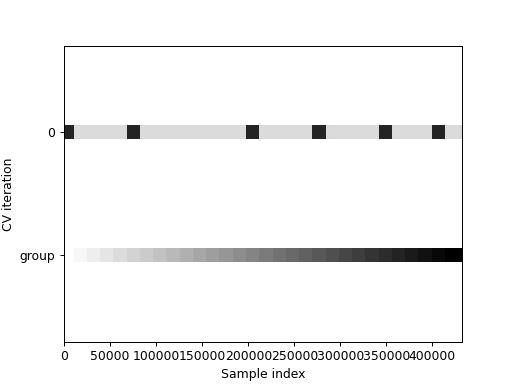

making cupy arrays
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.014
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.004 

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.016
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.005 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.094
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.092 

y #: 3 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.028
y #: 3 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.013 

y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.075
y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.042 

y #: 5 , Roll iter: 0 , CV rep

y #: 45 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.011
y #: 45 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.158 

y #: 46 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.021
y #: 46 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.0 

y #: 47 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.136
y #: 47 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.126 

y #: 48 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.063
y #: 48 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.043 

y #: 49 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.103
y #: 49 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.042 

y #: 50 , Roll iter: 0 , CV repeat #: 0 

y #: 90 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.098
y #: 90 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.075 

y #: 91 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.005
y #: 91 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.005 

y #: 92 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.16
y #: 92 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.097 

y #: 93 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.025
y #: 93 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.009 

y #: 94 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.034
y #: 94 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.013 

y #: 95 , Roll iter: 0 , CV repeat #: 0 

y #: 135 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.213
y #: 135 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.155 

y #: 136 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.208
y #: 136 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.159 

y #: 137 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.234
y #: 137 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.17 

y #: 138 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.146
y #: 138 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.067 

y #: 139 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.072
y #: 139 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.074 

y #: 140 , Roll iter: 0 , CV re

y #: 180 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.087
y #: 180 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.06 

y #: 181 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.03
y #: 181 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.009 

y #: 182 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.043
y #: 182 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.037 

y #: 183 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.051
y #: 183 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.012 

y #: 184 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.04
y #: 184 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.008 

y #: 185 , Roll iter: 0 , CV rep

y #: 225 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.023
y #: 225 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.009 

y #: 226 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.119
y #: 226 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.101 

y #: 227 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.121
y #: 227 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.056 

y #: 228 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.017
y #: 228 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.01 

y #: 229 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.057
y #: 229 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.016 

y #: 230 , Roll iter: 0 , CV r

y #: 270 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.075
y #: 270 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.009 

y #: 271 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.01
y #: 271 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: -0.014 

y #: 272 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.14
y #: 272 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.106 

y #: 273 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.046
y #: 273 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.037 

y #: 274 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , train R^2: 0.097
y #: 274 , Roll iter: 0 , CV repeat #: 0 , alpha val: 10000000 , l1_ratio: 0 , test  R^2: 0.024 

y #: 275 , Roll iter: 0 , CV re

In [208]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules.linear_regression import LinearRegression_sweep
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                StratifiedKFold, GroupShuffleSplit,
                                GroupKFold, StratifiedShuffleSplit)

group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

# OR:

# n_splits = 1
# cv = StratifiedKFold(n_splits, shuffle=False, random_state=None, )
# cv_idx = list(cv.split(X=scores.T, y=trial_types_aligned, groups=trial_types_aligned))

X = pca_scores[:, PCs_toUse].numpy()
# X = pos_array

y = spks_conv[:, neuron_toUse]
y = y - np.mean(y, axis=0)
y = y / np.std(y, axis=0)
# y = y[:,None]


n_nonzero_rolls = 0
min_roll = 60*10*Fs
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1

model_params_cuml_ElasticNet = {
        'fit_intercept': True,
        'normalize': False,
        'max_iter': 1000,
        'tol': 0.0001,
        'selection': 'cyclic',
}
model_params_sklearn_Ridge = {
#     'alpha':1.0, 
    'fit_intercept':True, 
    'normalize':'deprecated', 
    'copy_X':True, 
    'max_iter':None, 
    'tol':0.001, 
    'solver':'auto', 
#     'positive':False, 
    'random_state':None
}
model_params_cuml_Ridge = {
    'solver': 'eig', 
    'fit_intercept': True, 
    'normalize': False, 
    'handle': None, 
    'output_type': None, 
#     'verbose': False
}

l1_ratios = np.array([0])
# alphas = np.array([0.0001, 0.01, 10, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 1000000000])
alphas = np.array([10000000])

# prepare output variables for in-place computations
n_y = y.shape[1]
n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)

theta = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios, X.shape[1]))
intercept = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_train  = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_test   = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))

# Run regression sweep
theta, intercept, EV_train, EV_test, preds = LinearRegression_sweep(X,
                                                                y,
                                                                cv_idx,
                                                                alphas=alphas,
                                                                l1_ratios=l1_ratios,
                                                                rolls=rolls,
                                                                method_package='cuml',
                                                                method_model='Ridge',
                                                                compute_preds=True,
                                                                verbose=2,
                                                                theta_inPlace=theta, 
                                                                intercept_inPlace=intercept,
                                                                EV_train_inPlace=EV_train,
                                                                EV_test_inPlace=EV_test,
                                                                **model_params_cuml_Ridge
                                                                )

In [214]:
EV = np.empty((theta.shape[0], theta.shape[3]))
for iter_y in range(theta.shape[0]):
# for iter_y in range(3):
    for iter_alpha in range(theta.shape[3]):
        y_pred_tmp = theta[iter_y,:,:,iter_alpha,:,:].squeeze() @ X[cv_idx[0][1],:].T
        EV[iter_y, iter_alpha] = similarity.pairwise_orthogonalization(y[cv_idx[0][1], iter_y][:,None], y_pred_tmp[:,None])[1]

<IPython.core.display.Javascript object>


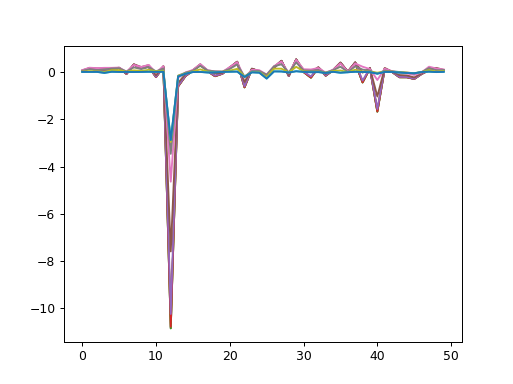

In [233]:
plt.figure()
plt.plot(EV_test.squeeze())

<IPython.core.display.Javascript object>


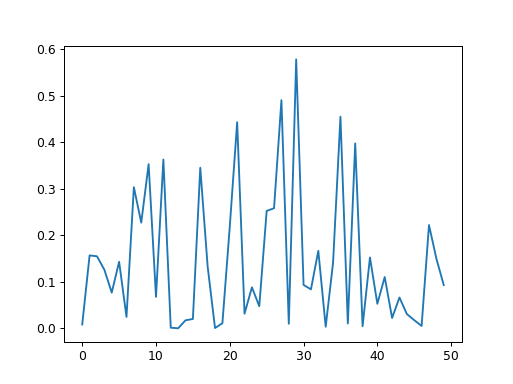

In [254]:
plt.figure()
plt.plot(EV.squeeze())

In [38]:
EV.mean(0)

array([0.36192392])

In [203]:
similarity.pairwise_orthogonalization(y[cv_idx[0][1], iter_y][:,None], y_pred_tmp[:,None])

(array([[-0.16668497, -0.23569377, -0.24289354, ..., -0.47835029,
         -0.44270835, -0.41476091]]),
 array([0.05994709]),
 0.05994708726786768,
 0.05994708726786768)

In [193]:
X[cv_idx[0][1]].T.shape

(200, 86400)

In [194]:
theta[iter_y,:,:,iter_alpha,:,:].squeeze().shape

(200,)

In [172]:
similarity.pairwise_orthogonalization(y[cv_idx[0][1]], preds.squeeze()[:,ii,:].T)

AssertionError: 

In [173]:
preds.squeeze()[:,ii,:].shape

(50, 432000)

In [176]:
y[cv_idx[0][1]].shape

(86400, 50)

In [88]:
np.maximum(0,EV_test.squeeze()).mean(0)

array([0.08266119, 0.08266143, 0.08268448, 0.08288539, 0.08418981,
       0.0812776 ])

In [95]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.08451055126554169

In [100]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.0702680324482953

In [125]:
np.maximum(0,EV_test.squeeze()).mean(0)

0.11739642839470169

In [124]:
np.maximum(0,EV_train.squeeze()).mean(0)

0.23401128399402846

<IPython.core.display.Javascript object>


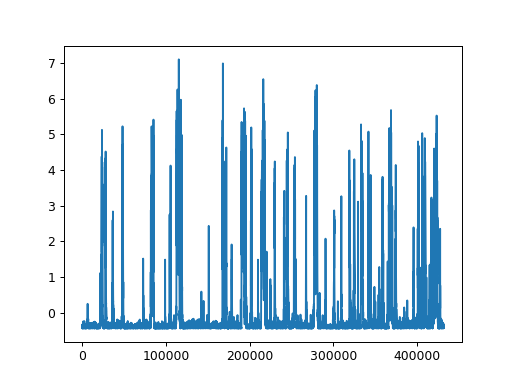

In [153]:
plt.figure()
plt.plot(y[:,0])

<IPython.core.display.Javascript object>


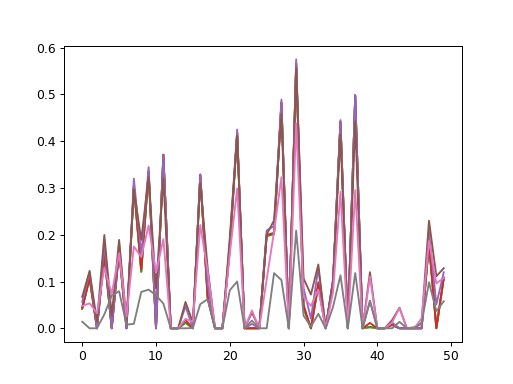

In [164]:
plt.figure()
plt.plot(np.maximum(0,EV_test.squeeze()))

In [178]:
X.shape

torch.Size([144000, 1, 300])

In [181]:
pca_scores.shape

torch.Size([432000, 1372])

In [179]:
pos_array.shape

(432000, 2744)

In [180]:
spks_conv.shape

(432000, 811)

In [25]:
{
    'alpha':1.0, 'fit_intercept':True, 'normalize':'deprecated', 'copy_X':True, 'max_iter':None, 'tol':0.001, 'solver':'auto', 'positive':False, 'random_state':None
}


{'alpha': 1.0,
 'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'positive': False,
 'random_state': None}